In [84]:
!pip install p3_data

In [85]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [86]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [87]:
# Load result files from P3 Test Driver
src_files = []
src_files += ['../../../tests/Pulsar-2.5.2-17.06.20-44tests/data/p3_test_driver/results/*.json']
raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 44 files...


In [88]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '0.6.0-2361.f273314-SNAPSHOT'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [89]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [90]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [64]:
# Show list of columns
clean_df.columns.values

array(['ansible', 'ansible_vars', 'aws-ec2', 'build', 'command_timed_out',
       'docker', 'driver', 'elapsed_sec', 'error', 'errors', 'exit_code',
       'git_commit', 'image', 'kubernetes', 'localWorker',
       'max_test_attempts', 'namespace', 'noop', 'numWorkers',
       'ombHelmPath', 'omb_results', 'output', 'print_output',
       'record_utc', 'record_uuid', 'result_filename', 'run_as_test',
       'sequence_in_test_batch', 'size_of_test_batch', 'status_html',
       'tarball', 'terraform', 'test', 'test_attempt', 'test_batch_uuid',
       'test_desc', 'test_driver_log_filename', 'test_driver_version',
       'test_uuid', 'undeploy', 'utc_begin', 'utc_end', 'loaded_filename',
       'driverName', 'ackQuorum', 'deduplicationEnabled', 'ensembleSize',
       'writeQuorum', 'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscriptionsPerTopic

In [65]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'pulsarVersion',
]

In [66]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'utc_begin',    
]

In [67]:
cols = param_cols + output_cols

In [68]:
# View most recent results
clean_df[cols].tail(38).T

test_uuid,fbefabf1-760d-4c8e-af40-4d960ff8bba5,999e48c1-6f29-4069-94cd-1b6ef8058157,1d84ea8d-e729-40a5-beb1-7db42d3391f4,02dcab19-da6b-48bf-8a98-b52daef31a45,b6537bc5-1f12-4443-a43c-eaf057b34629,a3387a61-7390-4ca5-ae0d-c08787644abd,adc073ce-1ff0-4832-bada-addd86541280,8004815b-089c-423a-98e7-e880af245e04,7e598442-eaed-41e0-ad89-1f26369f071d,7f605fdf-9325-473e-adb6-5e10af2ebaae,...,31ac6ef5-f72c-4243-bed8-ad42e559f32f,60b3d5f2-e07b-4e0f-8b5b-2ef2e7842f88,f53a3ff1-5ffb-4be7-b525-b86d4a4ca969,956e41bd-859c-4235-907e-5d08e6c598f7,7bbfbdf4-c934-45bd-819e-fa9a736e1e69,c2d98c26-22dc-4f21-a0bc-1d80c49878a9,5c21b5e9-25fe-4cfb-9a5d-7ebb590c8a55,ac6a4fd5-dad0-43c0-8549-60342cbd2ba8,1297941b-c403-4866-b753-4e7b29534afe,1e1f3ce4-89dd-4c40-8d0d-bbc0d6336ea5
numWorkloadWorkers,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
topics,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
partitionsPerTopic,1,1,1,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
producersPerTopic,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
subscriptionsPerTopic,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
consumerPerSubscription,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
testDurationMinutes,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,...,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY
git_commit,0efd5d1,0efd5d1,0efd5d1,0efd5d1,0efd5d1,0efd5d1,0efd5d1,0efd5d1,0efd5d1,0efd5d1,...,640ec1c,640ec1c,640ec1c,640ec1c,640ec1c,640ec1c,640ec1c,640ec1c,640ec1c,640ec1c
pulsarVersion,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,...,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2,2.5.2


In [69]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [70]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [71]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['pulsarVersion']).size()

pulsarVersion
2.5.2    44
dtype: int64

In [72]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
  #  driverName='Pravega',
  #  pravegaVersion='0.8.0-2508.30406cf',
#     pravegaVersion='0.6.0-2386.23b7340',
   # numWorkloadWorkers=2, 
    #topics=4,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

44

In [73]:
def latency_vs_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Publish Throughput (MB/s)'
    return result_df

In [74]:
def plot_latency_vs_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    plot_df = latency_vs_throughput_table(df)
    title = 'Pulsar 2.5.2 Helm 17.06.2020, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [75]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    #producersPerTopic=8,
    partitionsPerTopic=16,
    topics=4
)

In [76]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid


In [77]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,02dcab19-da6b-48bf-8a98-b52daef31a45
numWorkloadWorkers,4
topics,4
partitionsPerTopic,16
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,0efd5d1
pulsarVersion,2.5.2


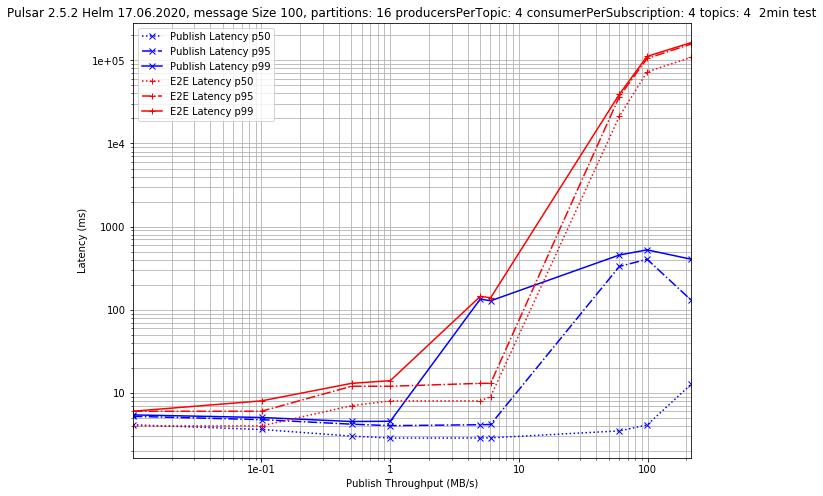

In [78]:
plot_latency_vs_throughput(filt_100_df)

In [79]:
latency_vs_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.010017,4.122,5.213,5.425,4.000,6.000,6.000,02dcab19-da6b-48bf-8a98-b52daef31a45
0.100144,3.622,4.755,5.047,4.000,6.000,8.000,b6537bc5-1f12-4443-a43c-eaf057b34629
0.501141,3.014,4.194,4.518,7.000,12.000,13.000,a3387a61-7390-4ca5-ae0d-c08787644abd
1.001926,2.857,4.027,4.546,8.000,12.000,14.000,adc073ce-1ff0-4832-bada-addd86541280
5.017746,2.861,4.130,134.467,8.000,13.000,145.000,8004815b-089c-423a-98e7-e880af245e04
6.029421,2.872,4.161,128.007,9.000,13.000,139.000,7e598442-eaed-41e0-ad89-1f26369f071d
60.370687,3.483,331.439,455.299,21192.063,36740.095,39153.151,7f605fdf-9325-473e-adb6-5e10af2ebaae
99.179286,4.102,404.677,524.899,72821.247,105609.215,111801.343,12de1f99-7db0-4be4-90ee-837fdaa206d4
216.979518,12.594,131.362,405.701,108548.095,156760.063,163322.879,58640bcc-0d0c-4329-8e55-1f3ae7cb7517


## Message Size 10 KB

In [81]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    #producersPerTopic=1,
    partitionsPerTopic=1,
)

In [82]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,777ce55e-2451-472e-892f-4a90aef22490
numWorkloadWorkers,4
topics,4
partitionsPerTopic,1
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,640ec1c
pulsarVersion,2.5.2


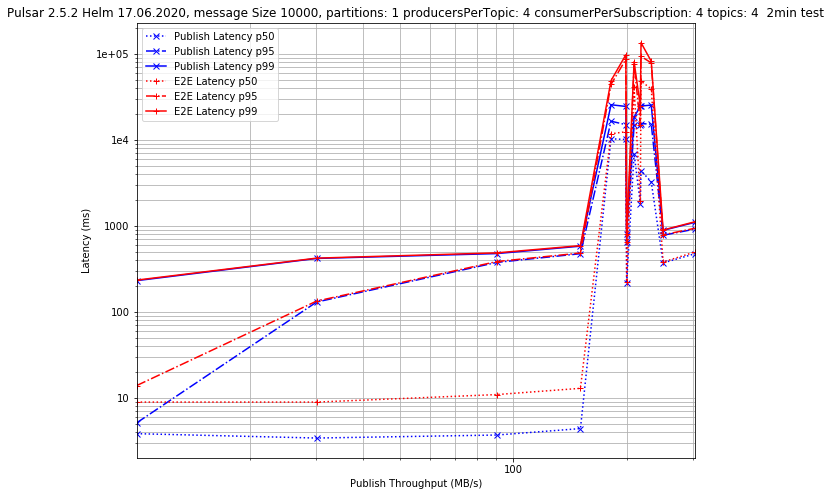

In [83]:
plot_latency_vs_throughput(filt_10000_df)

In [87]:
latency_vs_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.000000,0.000,0.000,0.000,0.000,0.000,0.000,c08fe61d-7dd8-4741-923b-a3d325af099d
0.000000,0.000,0.000,0.000,0.000,0.000,0.000,e8f3a159-7b1f-4cbe-b4fd-cf22a2a4afb7
0.000000,0.000,0.000,0.000,0.000,0.000,0.000,3351d5a8-11d5-4fe0-8ea6-414ade1d68b9
0.000000,0.000,0.000,0.000,0.000,0.000,0.000,a5c347e0-0ff4-450b-a7f9-be15e1bf2ade
10.015293,3.864,5.048,134.982,4.000,9.000,137.000,b16aac70-20cc-49e3-9631-182459040dd9
30.078611,3.551,128.994,362.899,4.000,137.000,371.001,2354ea92-b393-4344-bfaa-0fecc322f616
90.291892,3.679,342.325,485.547,9.000,350.001,493.001,37d7ace4-93d2-4eb3-bc2e-f1f5633a5b7b
151.173301,4.715,493.217,644.379,13.000,502.001,654.003,7e67a230-542e-4976-b35e-3dfc83a16017
200.712445,257.767,692.879,791.479,266.001,703.003,801.003,1203613d-1e1d-4f42-aa41-d59779b92a0c


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [106]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

2

In [107]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

/opt/conda/lib/python3.7/site-packages/p3_data/p3_common_lib.py:1177: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return hash(make_hashable(o))


,partitionsPerTopic,consumerPerSubscription,publishRateEventsPerSecMean,publishRateMBPerSecMean,publishLatencyMs50Pct,publishLatencyMs99Pct,endToEndLatencyMs50Pct,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,,
290945ce-f499-487a-b852-2447dd7dcac3,1,1,1.292670e+06,129.266979,5.642,12.215,18.000,297.001,2020-06-08 18:50:30.879180+00:00
545cb0d9-8461-40cb-a5fb-207a80a8ac5e,16,16,5.687447e+05,56.874471,4.010,40.880,52020.223,68873.215,2020-06-08 19:06:20.898770+00:00


# Analyze Latency Distribution

In [108]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

'290945ce-f499-487a-b852-2447dd7dcac3'

In [109]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

In [110]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [111]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

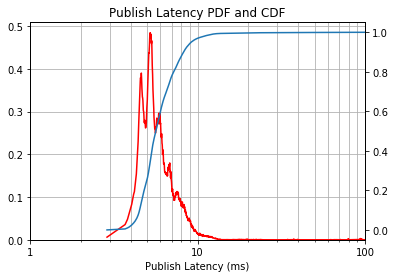

In [112]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [113]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

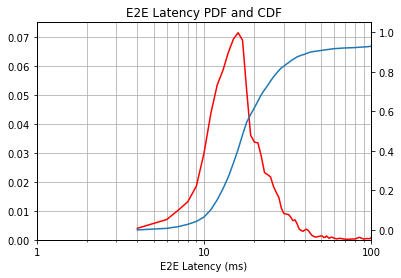

In [114]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

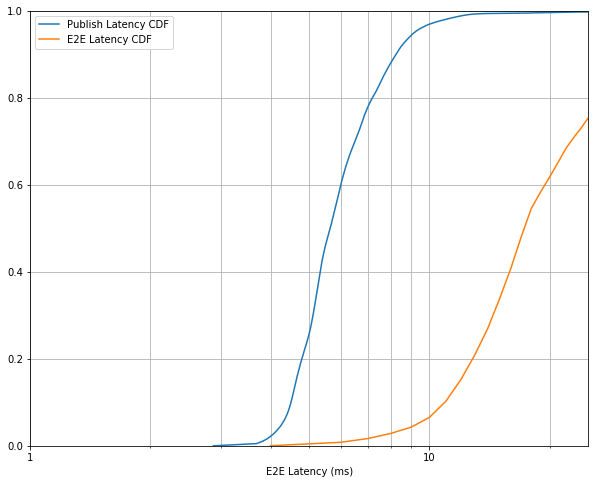

In [115]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [26]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    driverName='Pravega',
    numWorkloadWorkers=4, 
    topics=1,
    testDurationMinutes=15,
    size_of_test_batch=(2,1000), # between
    aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=100,
    producersPerTopic=32,
    partitionsPerTopic=16,    
)
len(filt_df)

NameError: name 'clean_df' is not defined

In [27]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.6.0-2361.f273314',
)
len(filt1_df)

NameError: name 'filt_df' is not defined

In [28]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.6.0-2386.23b7340',
)
len(filt2_df)

NameError: name 'filt_df' is not defined

In [29]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

NameError: name 'filt1_df' is not defined

In [30]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [31]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='Publish')

NameError: name 'filt1_df' is not defined

In [32]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='EndToEnd')

NameError: name 'filt1_df' is not defined